In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)
        
        # Calculate standard deviations
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)
        
        # Universal maximum scaling factor λ
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle θ for the u-Δ²u ellipse
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U
    
    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u_filtered_despiked[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_progress(self, iteration):
        """Plot the data points and the ellipses."""
        plt.figure(figsize=(8, 4))
        plt.scatter(self.u, self.dU, label='Data Points', color='blue')
        plt.scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        
        # Plot the u-Δu ellipse (unrotated, θ = 0)
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        plt.plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        
        plt.xlabel('u (Velocity)')
        plt.ylabel('Δu (First Derivative)')
        plt.title(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.show()

    def iterate_despiking(self, max_iterations=10, tolerance=5):
        """Iteratively despike until the number of bad points is below the tolerance."""
        for i in range(max_iterations):
            self.find_bad_indices()
            self.plot_progress(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking()
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")


C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_15008\2839529439.py:36: RuntimeWarning: invalid value encountered in sqrt
  self.a2 = np.sqrt(a2_squared)
C:\Users\Hrishabh\AppData\Local\Temp\ipykernel_15008\2839529439.py:37: RuntimeWarning: invalid value encountered in sqrt
  self.b2 = np.sqrt(b2_squared)


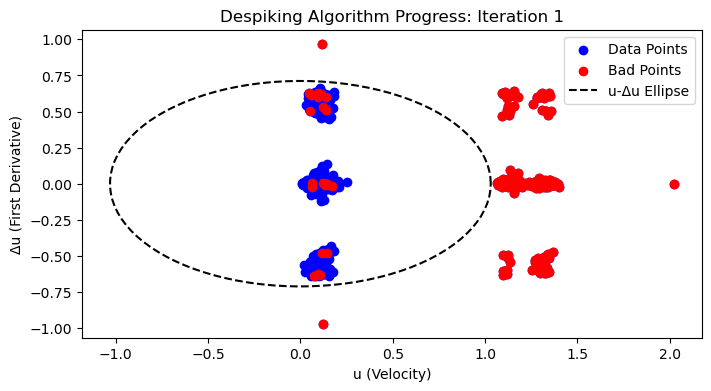

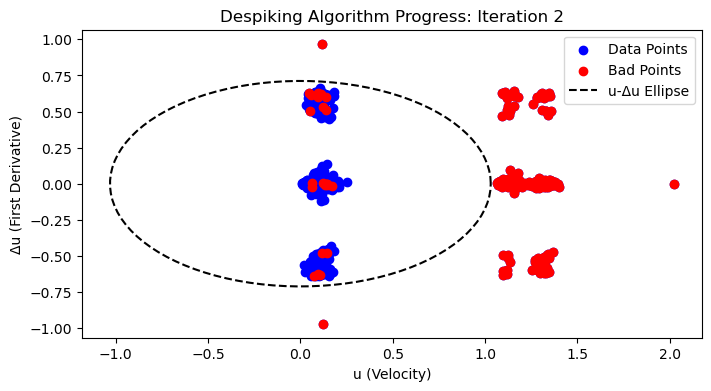

Maximum iterations reached with 351 bad indices remaining.


In [49]:
# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Calculate ellipse axes
adv_data.calculate_ellipse_axes()

# Run the iterative despiking process
adv_data.iterate_despiking(max_iterations=2, tolerance=5)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)
        
        # Calculate standard deviations
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)
        
        # Universal maximum scaling factor λ
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle θ for the u-Δ²u ellipse
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        theta = np.arctan2(self.u, self.d2U)  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U

        print(f"Bad Indices = {np.sum(self.bad_indices)}")
    
    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_progress(self, iteration):
        """Plot the data points and the ellipses."""
        plt.figure(figsize=(10, 6))
        plt.scatter(self.u, self.dU, label='Data Points', color='blue')
        plt.scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        
        # Plot the u-Δu ellipse (unrotated, θ = 0)
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        plt.plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        
        plt.xlabel('u (Velocity)')
        plt.ylabel('Δu (First Derivative)')
        plt.title(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.show()

    def iterate_despiking(self, max_iterations=10, tolerance=5):
        """Iteratively despike until the number of bad points is below the tolerance."""
        for i in range(max_iterations):
            self.find_bad_indices()
            self.plot_progress(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking()
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")


Bad Indices = 322


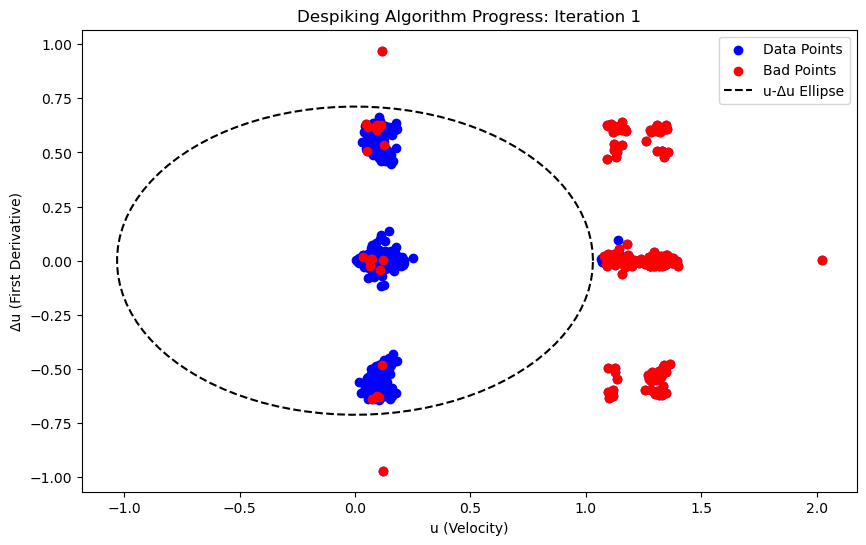

Bad Indices = 99


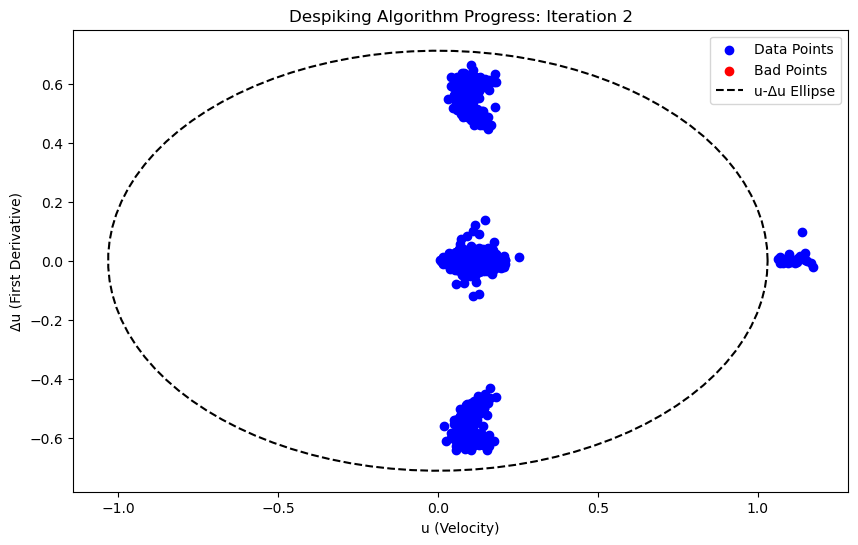

Maximum iterations reached with 99 bad indices remaining.


In [43]:
# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Calculate ellipse axes
adv_data.calculate_ellipse_axes()

# Run the iterative despiking process
adv_data.iterate_despiking(max_iterations=2, tolerance=5)


Bad Indices = 322


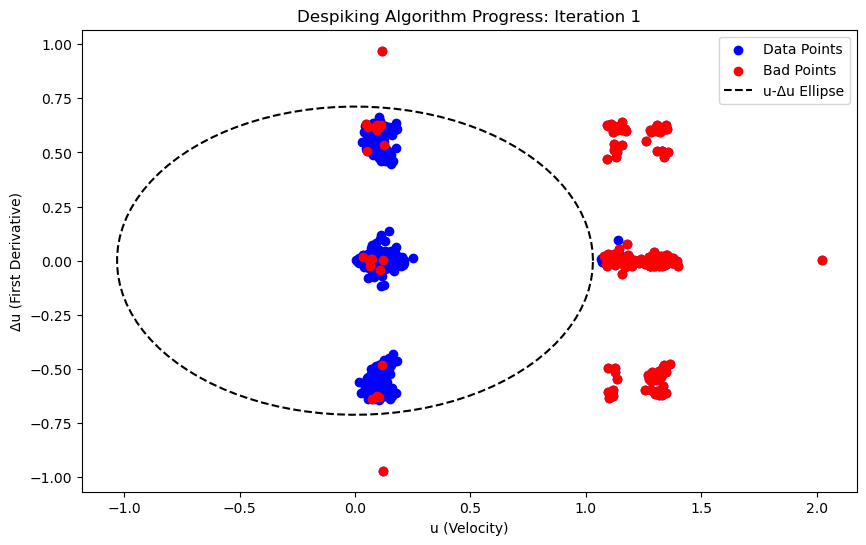

Bad Indices = 99


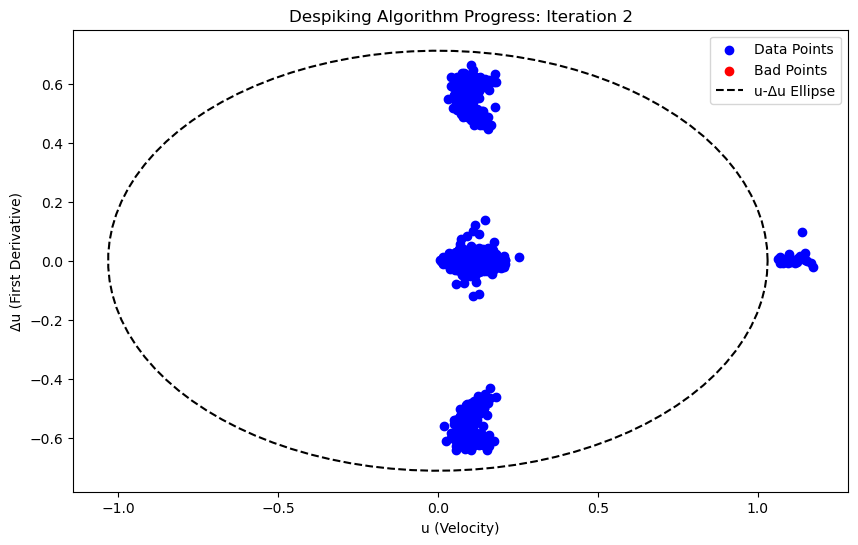

Maximum iterations reached with 99 bad indices remaining.


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        
        # Derivatives need to be computed once the velocity data is loaded
        self.calculate_derivatives()

    def calculate_derivatives(self):
        """Calculate first and second derivatives of velocity."""
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)

    def calculate_standard_deviations(self):
        """Calculate standard deviations for velocity and its derivatives."""
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)

    def calculate_lambda(self):
        """Calculate the universal maximum scaling factor λ."""
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        self.calculate_standard_deviations()
        self.calculate_lambda()
        
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        # Correct theta calculation based on the assignment
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))
        
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        # Solving for a2^2 and b2^2 using the given set of equations
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U

        print(f"Bad Indices = {np.sum(self.bad_indices)}")
    
    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_progress(self, iteration):
        """Plot the data points and the ellipses."""
        plt.figure(figsize=(10, 6))
        plt.scatter(self.u, self.dU, label='Data Points', color='blue')
        plt.scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        
        # Plot the u-Δu ellipse (unrotated, θ = 0)
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        plt.plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        
        plt.xlabel('u (Velocity)')
        plt.ylabel('Δu (First Derivative)')
        plt.title(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.show()

    def iterate_despiking(self, max_iterations=10, tolerance=5):
        """Iteratively despike until the number of bad points is below the tolerance."""
        for i in range(max_iterations):
            self.find_bad_indices()
            self.plot_progress(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking()
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")

# Example usage in the Jupyter Notebook:
# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Step-by-step implementation
adv_data.calculate_ellipse_axes()  # Calculate ellipse axes
adv_data.iterate_despiking(max_iterations=2, tolerance=5)  # Run despiking algorithm


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [40]:
class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        
        # Derivatives need to be computed once the velocity data is loaded
        self.calculate_derivatives()

    def calculate_derivatives(self):
        """Calculate first and second derivatives of velocity."""
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)

    def calculate_standard_deviations(self):
        """Calculate standard deviations for velocity and its derivatives."""
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)

    def calculate_lambda(self):
        """Calculate the universal maximum scaling factor λ."""
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        self.calculate_standard_deviations()
        self.calculate_lambda()
        
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        # Correct theta calculation based on the assignment
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))
        
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        # Solving for a2^2 and b2^2 using the given set of equations
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U

        print(f"Bad Indices = {np.sum(self.bad_indices)}")
    
    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_progress(self, iteration):
        """Plot the data points and the ellipses."""
        plt.figure(figsize=(10, 6))
        plt.scatter(self.u, self.dU, label='Data Points', color='blue')
        plt.scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        
        # Plot the u-Δu ellipse (unrotated, θ = 0)
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        plt.plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        
        plt.xlabel('u (Velocity)')
        plt.ylabel('Δu (First Derivative)')
        plt.title(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.show()

    def iterate_despiking(self, max_iterations=10, tolerance=5):
        """Iteratively despike until the number of bad points is below the tolerance."""
        for i in range(max_iterations):
            self.find_bad_indices()
            self.plot_progress(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking()
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")


Bad Indices = 322


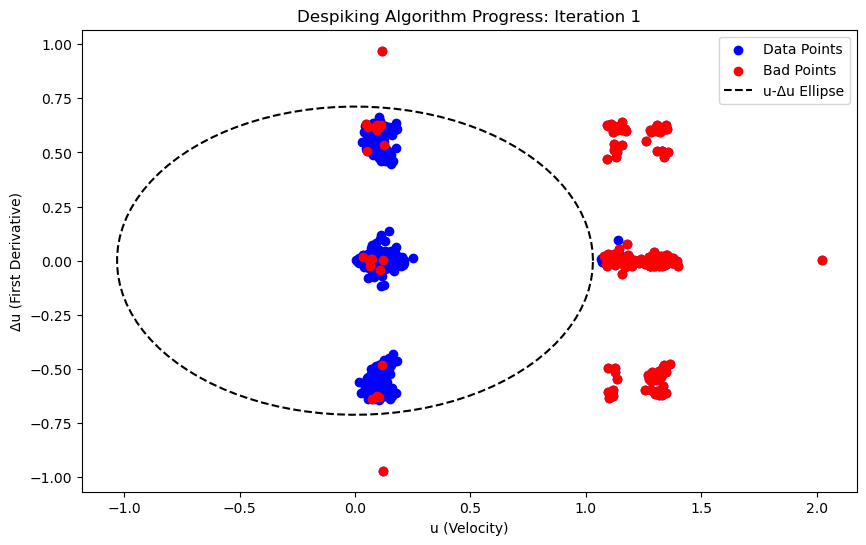

Bad Indices = 99


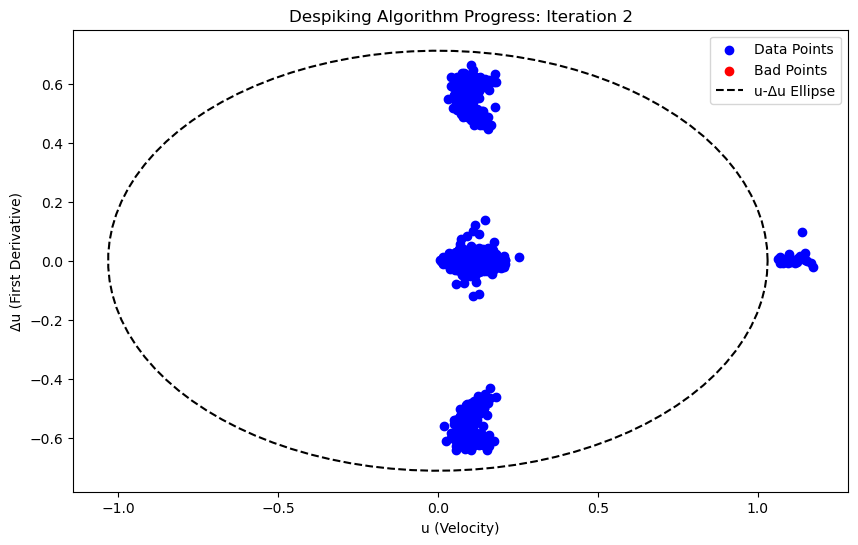

Maximum iterations reached with 99 bad indices remaining.


In [41]:
# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Step-by-step implementation
adv_data.calculate_ellipse_axes()  # Calculate ellipse axes
adv_data.iterate_despiking(max_iterations=2, tolerance=5)  # Run despiking algorithm


Bad Indices = 322


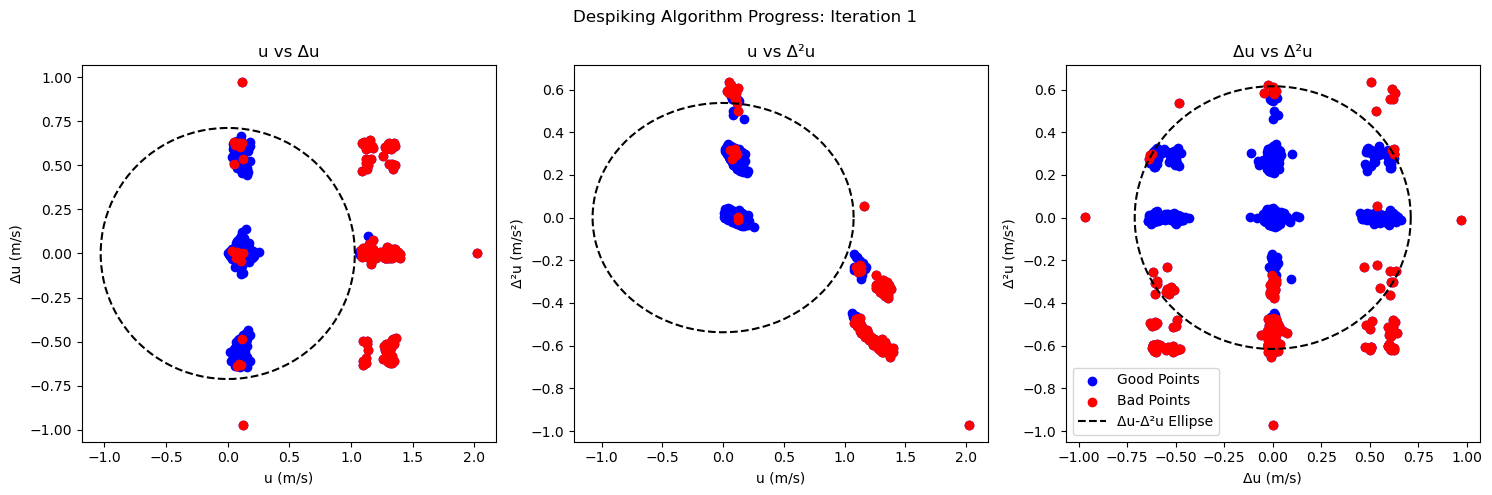

Bad Indices = 99


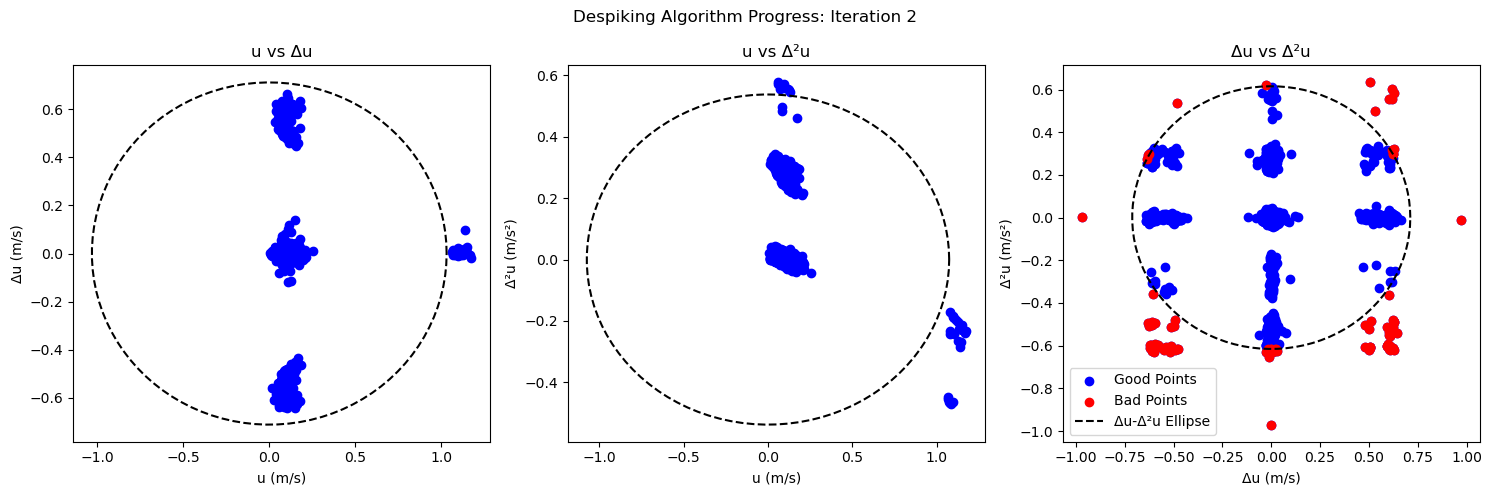

Maximum iterations reached with 99 bad indices remaining.


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        
        # Derivatives need to be computed once the velocity data is loaded
        self.calculate_derivatives()

    def calculate_derivatives(self):
        """Calculate first and second derivatives of velocity."""
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)

    def calculate_standard_deviations(self):
        """Calculate standard deviations for velocity and its derivatives."""
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)

    def calculate_lambda(self):
        """Calculate the universal maximum scaling factor λ."""
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        self.calculate_standard_deviations()
        self.calculate_lambda()
        
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        # Correct theta calculation based on the assignment
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))
        
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        # Solving for a2^2 and b2^2 using the given set of equations
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U

        print(f"Bad Indices = {np.sum(self.bad_indices)}")
    
    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_progress(self, iteration):
        """Plot the data points and the ellipses at each iteration for all three relationships."""
        
        # Set up subplots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        # u vs Δu plot (left)
        axs[0].scatter(self.u, self.dU, label='Good Points', color='blue')
        axs[0].scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        axs[0].plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        axs[0].set_xlabel('u (m/s)')
        axs[0].set_ylabel('Δu (m/s)')
        axs[0].set_title('u vs Δu')

        # u vs Δ²u plot (middle)
        axs[1].scatter(self.u, self.d2U, label='Good Points', color='blue')
        axs[1].scatter(self.u[self.bad_indices], self.d2U[self.bad_indices], label='Bad Points', color='red')
        ellipse_u_d2U_x = self.a2 * np.cos(theta)
        ellipse_u_d2U_y = self.b2 * np.sin(theta)
        axs[1].plot(ellipse_u_d2U_x, ellipse_u_d2U_y, 'k--', label="u-Δ²u Ellipse")
        axs[1].set_xlabel('u (m/s)')
        axs[1].set_ylabel('Δ²u (m/s²)')
        axs[1].set_title('u vs Δ²u')

        # Δu vs Δ²u plot (right)
        axs[2].scatter(self.dU, self.d2U, label='Good Points', color='blue')
        axs[2].scatter(self.dU[self.bad_indices], self.d2U[self.bad_indices], label='Bad Points', color='red')
        ellipse_dU_d2U_x = self.a3 * np.cos(theta)
        ellipse_dU_d2U_y = self.b3 * np.sin(theta)
        axs[2].plot(ellipse_dU_d2U_x, ellipse_dU_d2U_y, 'k--', label="Δu-Δ²u Ellipse")
        axs[2].set_xlabel('Δu (m/s)')
        axs[2].set_ylabel('Δ²u (m/s²)')
        axs[2].set_title('Δu vs Δ²u')

        # Add legend and overall title
        fig.suptitle(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def iterate_despiking(self, max_iterations=10, tolerance=5):
        """Iteratively despike until the number of bad points is below the tolerance."""
        for i in range(max_iterations):
            self.find_bad_indices()
            self.plot_progress(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking()
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")


# Example usage in the Jupyter Notebook:
# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Step-by-step implementation
adv_data.calculate_ellipse_axes()  # Calculate ellipse axes
adv_data.iterate_despiking(max_iterations=10, tolerance=5)  # Run despiking algorithm


Bad Indices = 322


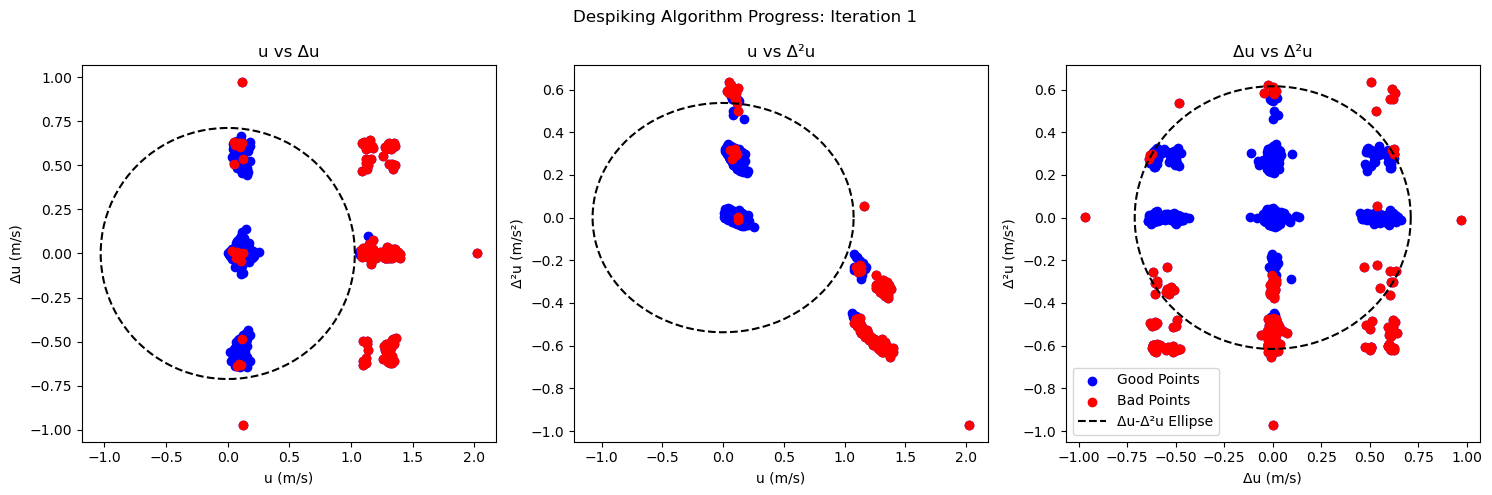

Bad Indices = 99


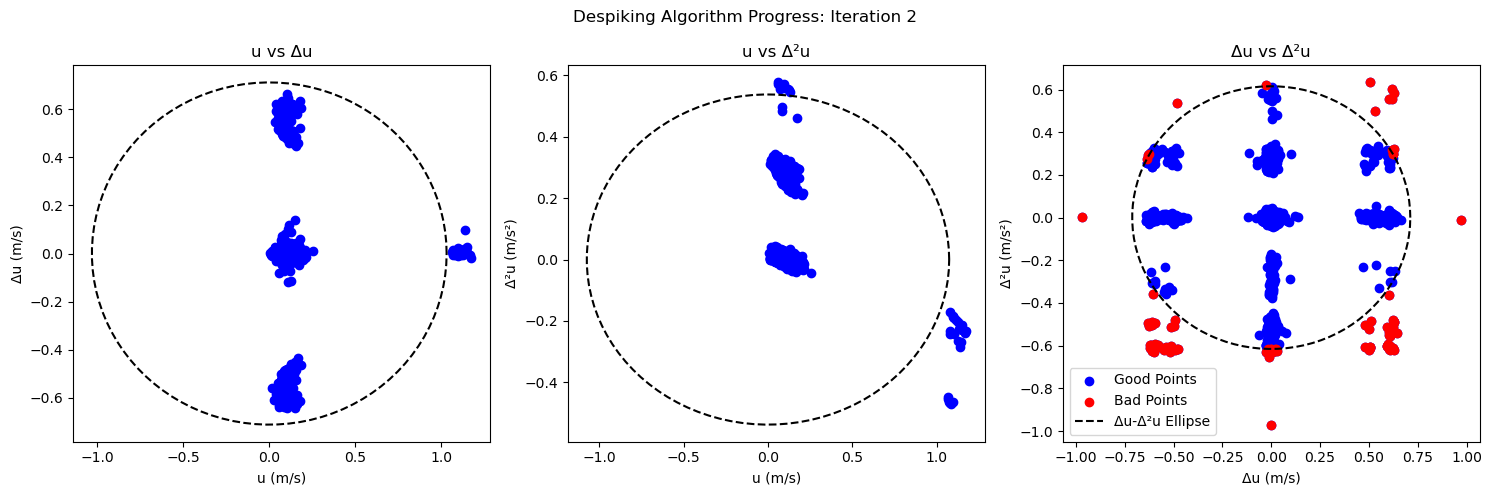

Bad Indices = 99


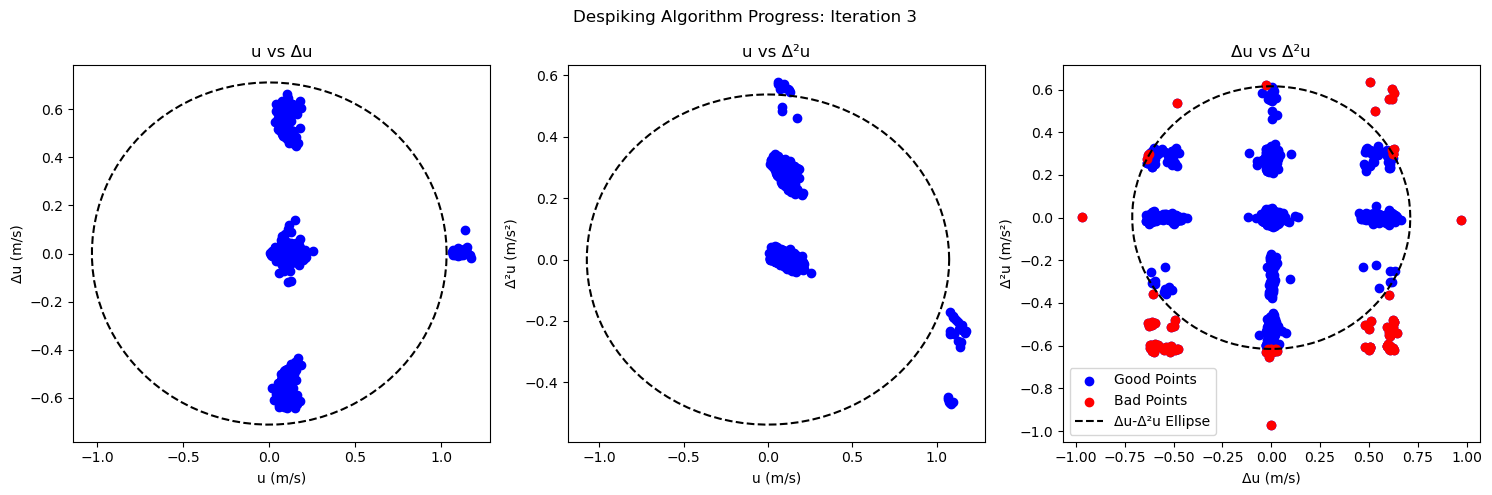

Bad Indices = 99


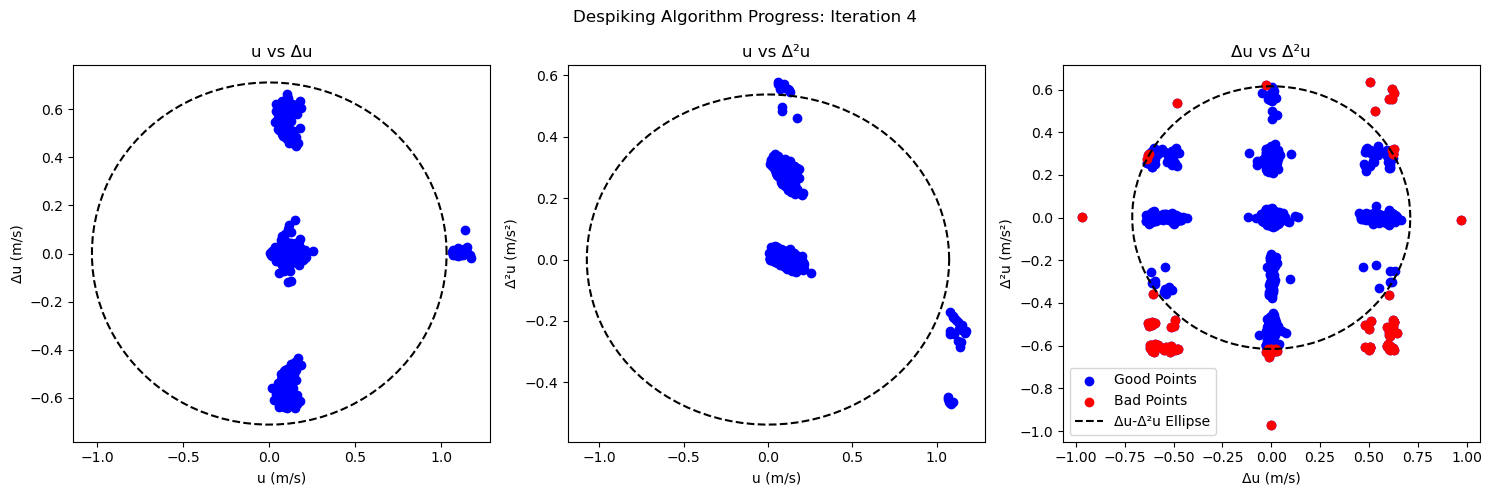

Bad Indices = 99


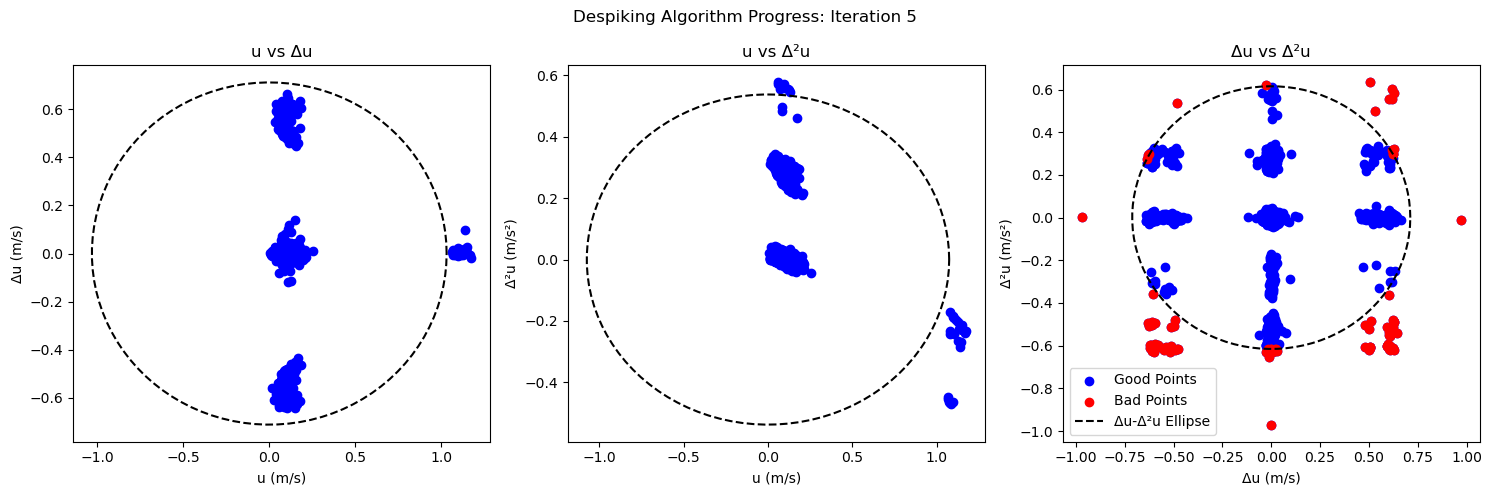

Maximum iterations reached with 99 bad indices remaining.


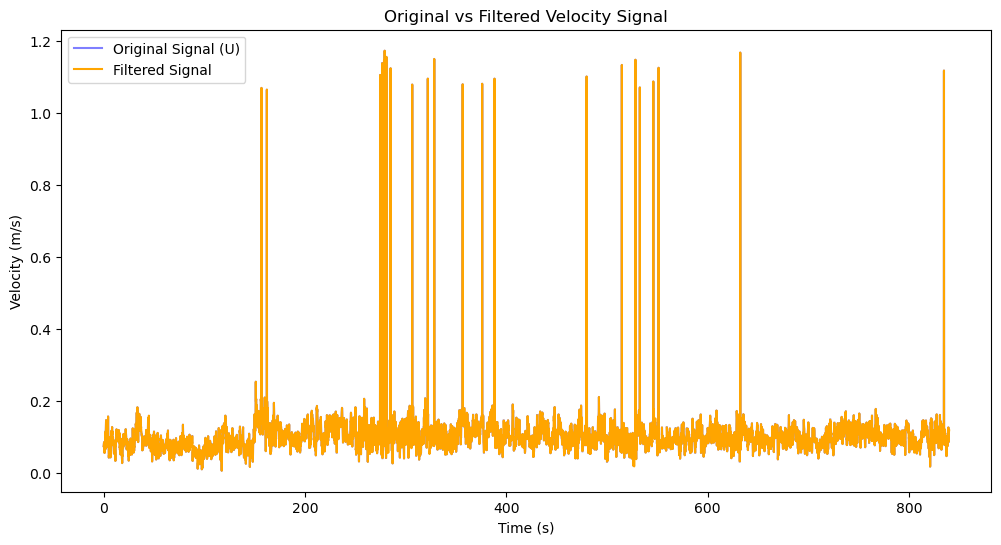

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        """Initialize the class with the path to the ADV data file."""
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()  # Time data
        self.u = data['U'].to_numpy()  # Velocity data (U)
        
        # Derivatives need to be computed once the velocity data is loaded
        self.calculate_derivatives()

    def calculate_derivatives(self):
        """Calculate first and second derivatives of velocity."""
        self.dU = np.gradient(self.u)  # First derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # Second derivative (Δ²U)

    def calculate_standard_deviations(self):
        """Calculate standard deviations for velocity and its derivatives."""
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)

    def calculate_lambda(self):
        """Calculate the universal maximum scaling factor λ."""
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes(self):
        """Calculate major and minor axes for ellipses."""
        self.calculate_standard_deviations()
        self.calculate_lambda()
        
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        # Correct theta calculation based on the assignment
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))
        
        A = (self.lambda_max * self.sigma_U)**2
        B = (self.lambda_max * self.sigma_d2U)**2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        # Solving for a2^2 and b2^2 using the given set of equations
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)
        
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        """Find indices where data falls outside the bounds of ellipses."""
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))  # Rotation angle for each point
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1
        
        # Combine all bad indices
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U

        print(f"Bad Indices = {np.sum(self.bad_indices)}")
    
    def apply_despiking(self):
        """Set bad velocity values to NaN and impute them."""
        self.u_filtered_despiked = np.copy(self.u)
        self.u[self.bad_indices] = np.nan
        
        # Interpolate over NaN values using linear interpolation
        self.u_filtered_despiked = pd.Series(self.u_filtered_despiked).interpolate(method='linear').to_numpy()

    def plot_progress(self, iteration):
        """Plot the data points and the ellipses at each iteration for all three relationships."""
        
        # Set up subplots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        # u vs Δu plot (left)
        axs[0].scatter(self.u, self.dU, label='Good Points', color='blue')
        axs[0].scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        axs[0].plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        axs[0].set_xlabel('u (m/s)')
        axs[0].set_ylabel('Δu (m/s)')
        axs[0].set_title('u vs Δu')

        # u vs Δ²u plot (middle)
        axs[1].scatter(self.u, self.d2U, label='Good Points', color='blue')
        axs[1].scatter(self.u[self.bad_indices], self.d2U[self.bad_indices], label='Bad Points', color='red')
        ellipse_u_d2U_x = self.a2 * np.cos(theta)
        ellipse_u_d2U_y = self.b2 * np.sin(theta)
        axs[1].plot(ellipse_u_d2U_x, ellipse_u_d2U_y, 'k--', label="u-Δ²u Ellipse")
        axs[1].set_xlabel('u (m/s)')
        axs[1].set_ylabel('Δ²u (m/s²)')
        axs[1].set_title('u vs Δ²u')

        # Δu vs Δ²u plot (right)
        axs[2].scatter(self.dU, self.d2U, label='Good Points', color='blue')
        axs[2].scatter(self.dU[self.bad_indices], self.d2U[self.bad_indices], label='Bad Points', color='red')
        ellipse_dU_d2U_x = self.a3 * np.cos(theta)
        ellipse_dU_d2U_y = self.b3 * np.sin(theta)
        axs[2].plot(ellipse_dU_d2U_x, ellipse_dU_d2U_y, 'k--', label="Δu-Δ²u Ellipse")
        axs[2].set_xlabel('Δu (m/s)')
        axs[2].set_ylabel('Δ²u (m/s²)')
        axs[2].set_title('Δu vs Δ²u')

        # Add legend and overall title
        fig.suptitle(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_filtered_signal(self):
        """Plot the original signal and the filtered signal."""
        plt.figure(figsize=(12, 6))
        plt.plot(self.t, self.u, label='Original Signal (U)', color='blue', alpha=0.5)
        plt.plot(self.t, self.u_filtered_despiked, label='Filtered Signal', color='orange')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Original vs Filtered Velocity Signal')
        plt.legend()
        plt.show()

    def iterate_despiking(self, max_iterations=10, tolerance=5):
        """Iteratively despike until the number of bad points is below the tolerance."""
        for i in range(max_iterations):
            self.find_bad_indices()
            self.plot_progress(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking()
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")

        # After despiking, plot the original and filtered signal
        self.plot_filtered_signal()

# Example usage in the Jupyter Notebook:
# Initialize the AdvData class with the 'adv.csv' file
adv_data = AdvData('adv.csv')

# Step-by-step implementation
adv_data.calculate_ellipse_axes()  # Calculate ellipse axes
adv_data.iterate_despiking(max_iterations=5, tolerance=5)  # Run despiking algorithm


Bad Indices = 322


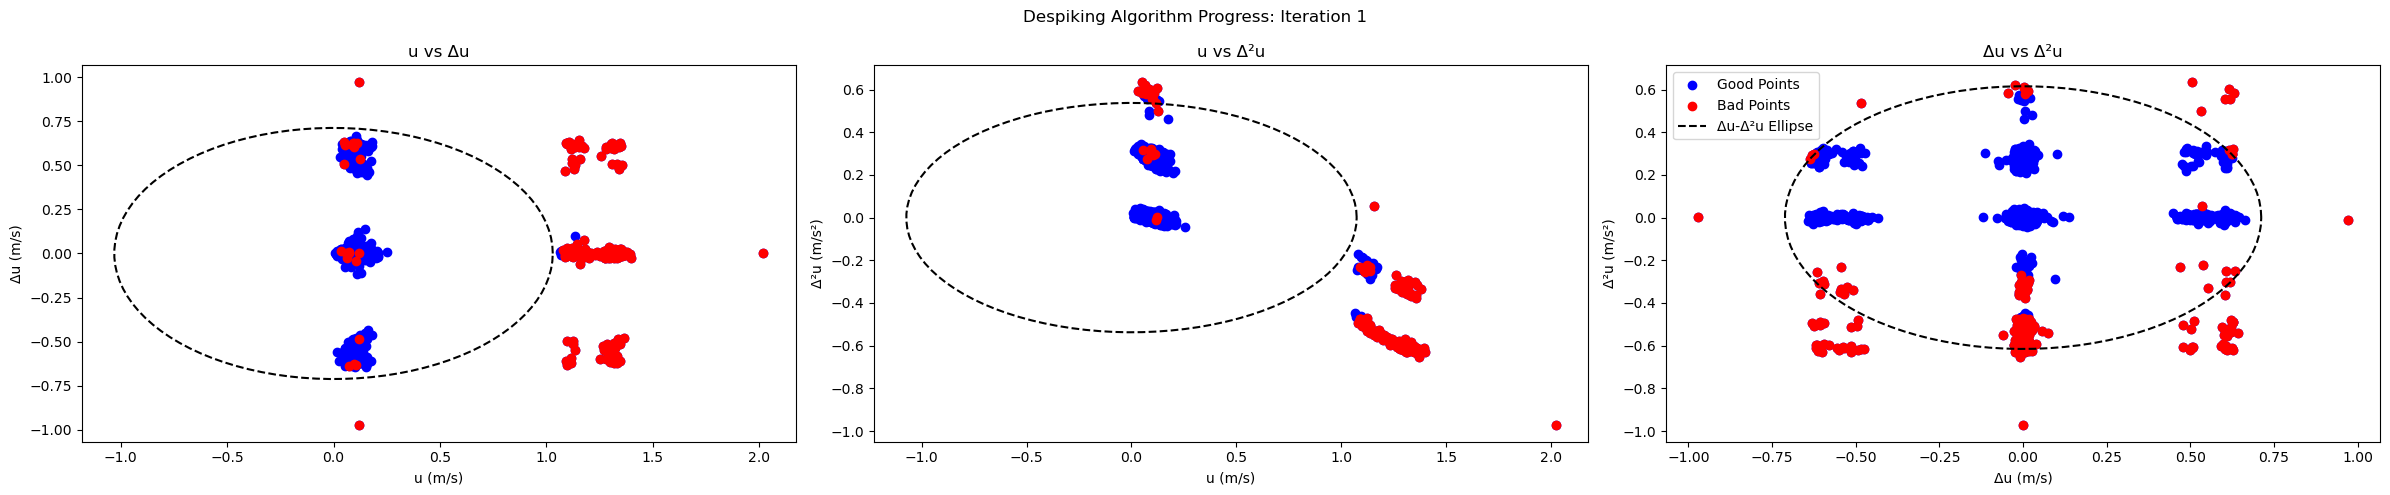

Iteration 1 complete.
Bad Indices = 113


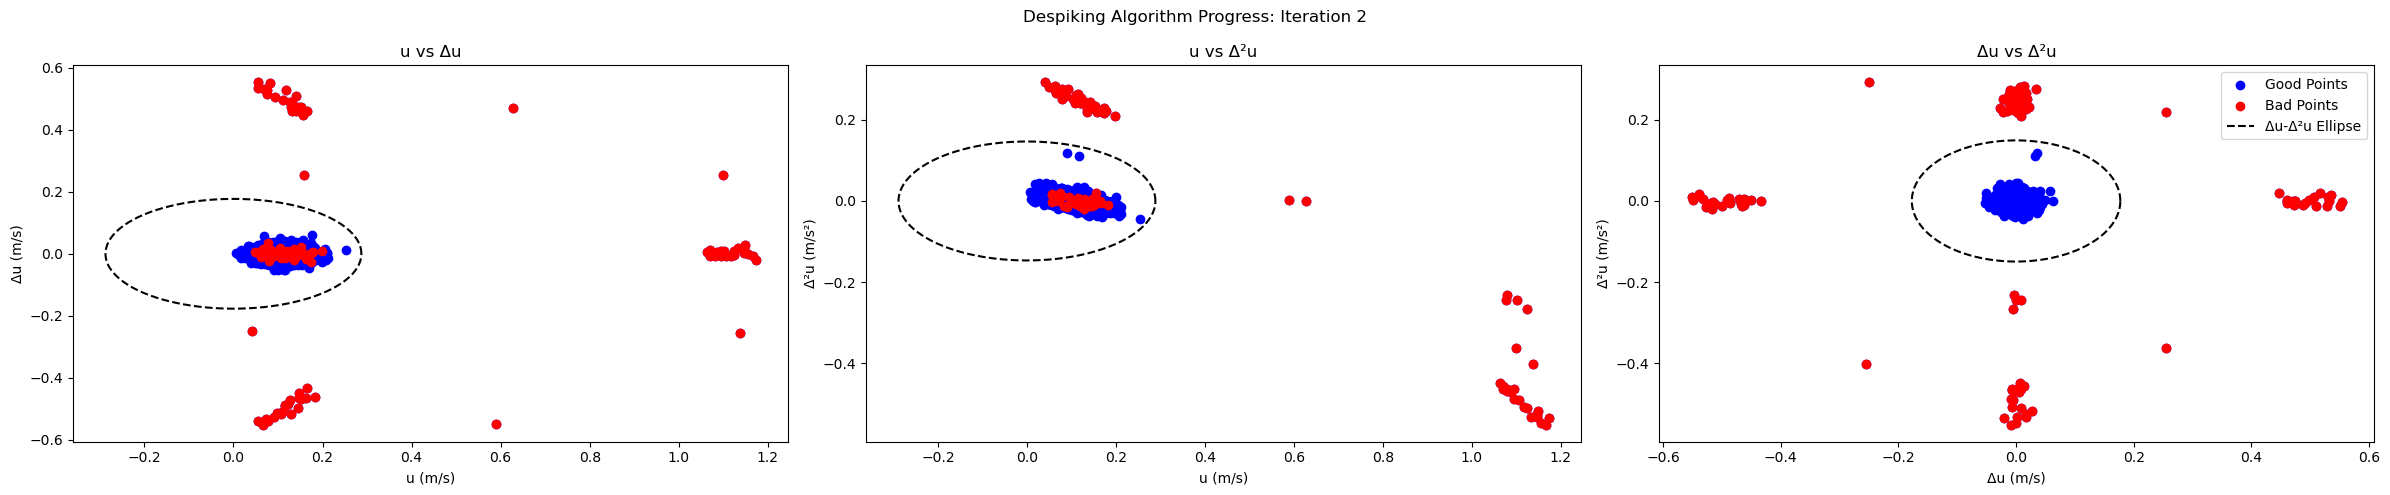

Iteration 2 complete.
Bad Indices = 34


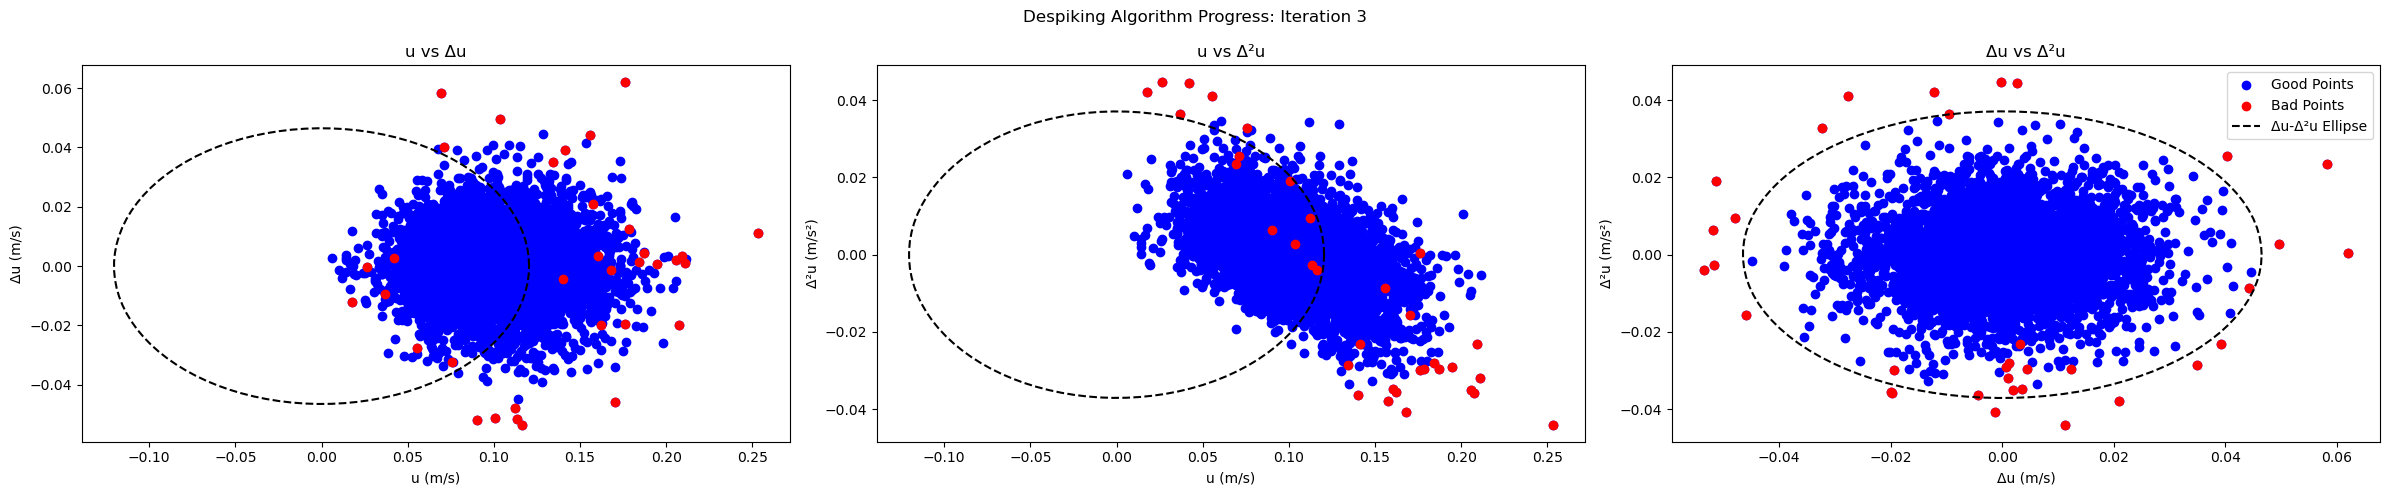

Iteration 3 complete.
Bad Indices = 3


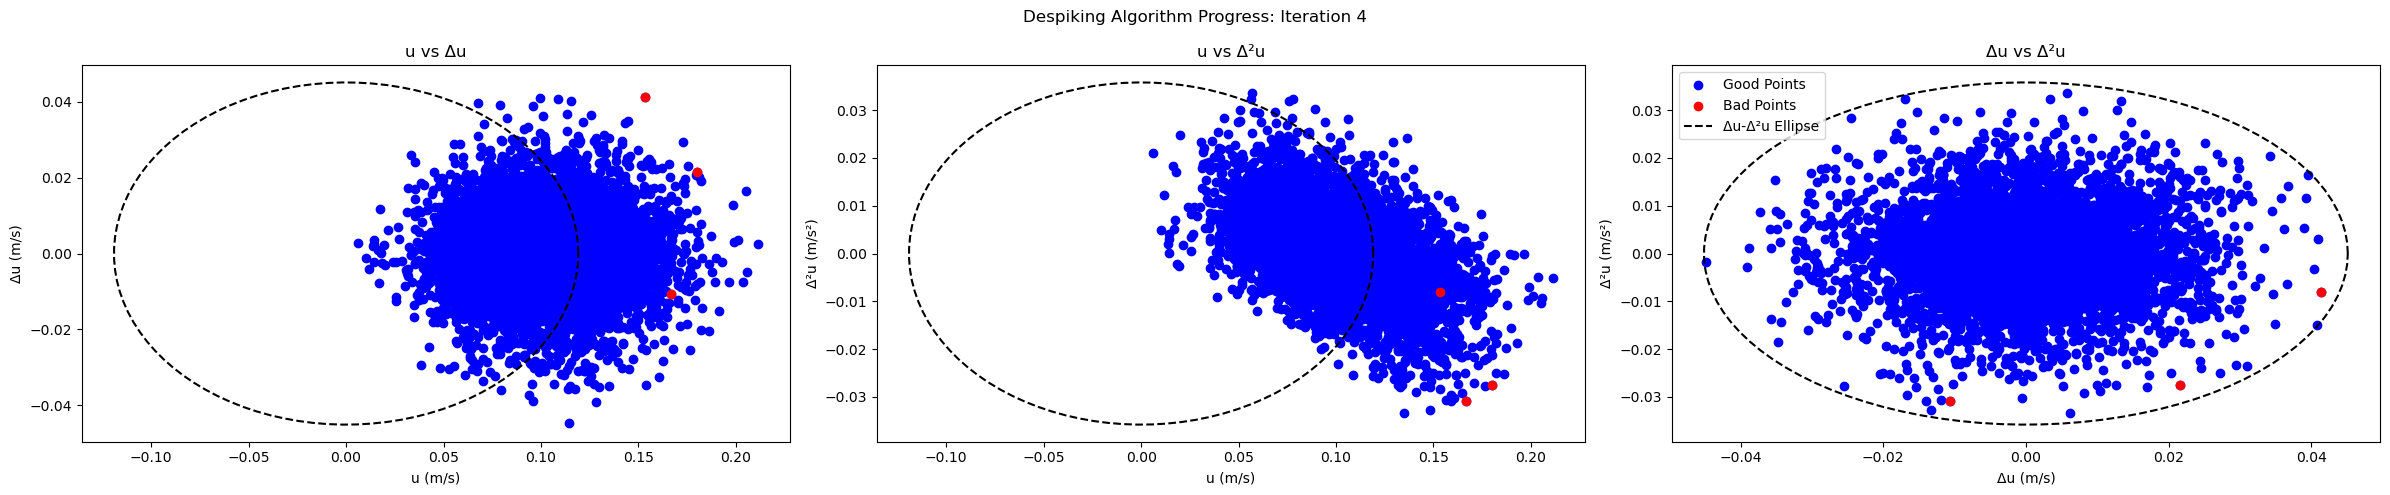

Iteration 4 complete.
Bad Indices = 1


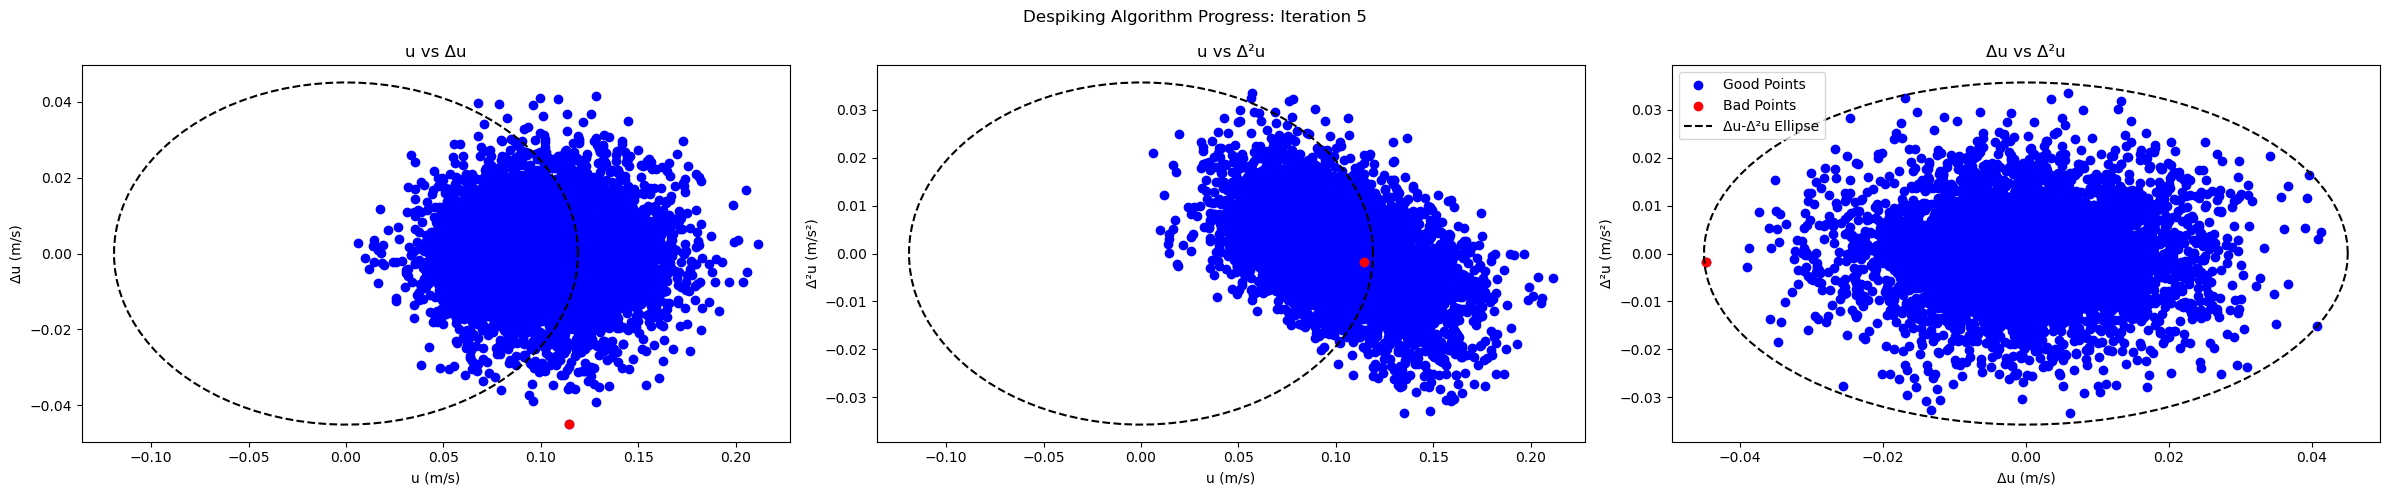

Iteration 5 complete.
Maximum iterations reached with 1 bad indices remaining.


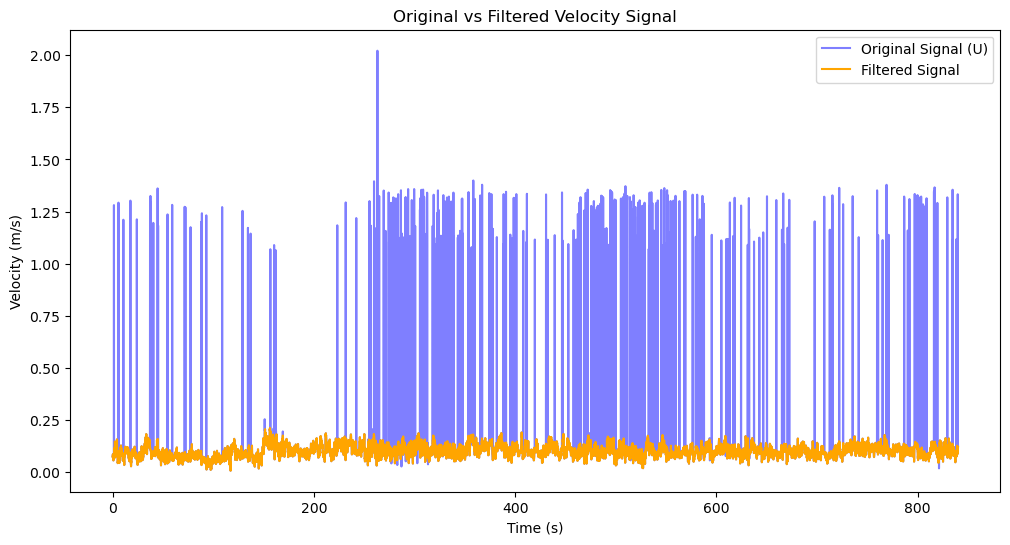

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class AdvData:
    def __init__(self, file_path):
        # Initialize the class with the path to the ADV data file.
        data = pd.read_csv(file_path)
        self.t = data['time'].to_numpy()
        self.u = data['U'].to_numpy()
        self.original_u = self.u.copy()
        self.calculate_derivatives()

    def calculate_derivatives(self):
        # Calculate first and second derivatives of velocity.
        self.dU = np.gradient(self.u)  # 1st derivative (ΔU)
        self.d2U = np.gradient(self.dU)  # 2nd derivative (Δ²U)

    def calculate_standard_deviations(self):
        # Calculate standard deviations for velocity and its derivatives.
        self.sigma_U = np.std(self.u)
        self.sigma_dU = np.std(self.dU)
        self.sigma_d2U = np.std(self.d2U)

    def calculate_lambda(self):
        """Calculate the universal maximum scaling factor λ."""
        self.n = len(self.u)
        self.lambda_max = np.sqrt(2 * np.log(self.n))

    def calculate_ellipse_axes(self):
        # Calculate major and minor axes for ellipses.
        self.calculate_standard_deviations()
        self.calculate_lambda()
        
        self.a1 = self.lambda_max * self.sigma_U
        self.b1 = self.lambda_max * self.sigma_dU
        
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))
        A = (self.lambda_max * self.sigma_U) ** 2
        B = (self.lambda_max * self.sigma_d2U) ** 2
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        a2_squared = (A * cos_theta**2 - B * sin_theta**2) / (cos_theta**2 - sin_theta**2)
        b2_squared = (B * cos_theta**2 - A * sin_theta**2) / (cos_theta**2 - sin_theta**2)  

        self.a2 = np.sqrt(a2_squared)
        self.b2 = np.sqrt(b2_squared)    
        self.a3 = self.lambda_max * self.sigma_dU
        self.b3 = self.lambda_max * self.sigma_d2U

    def find_bad_indices(self):
        # Finding indices where data falls outside the bounds of ellipses.
        U_mean = np.mean(self.u)
        dU_mean = np.mean(self.dU)
        d2U_mean = np.mean(self.d2U)
        
        # Check for bad indices for u-Δu ellipse
        bad_u_dU = (((self.u - U_mean)**2) / self.a1**2) + (((self.dU - dU_mean)**2) / self.b1**2) > 1
        
        # Check for bad indices for u-Δ²u ellipse
        theta = np.arctan2(np.sum(self.u * self.d2U), np.sum(self.u**2))
        bad_u_d2U = (
            ((np.cos(theta) * (self.u - U_mean) + np.sin(theta) * (self.d2U - d2U_mean))**2) / self.a2**2
            + ((np.sin(theta) * (self.u - U_mean) - np.cos(theta) * (self.d2U - d2U_mean))**2) / self.b2**2
        ) > 1
        
        # Check for bad indices
        bad_dU_d2U = (((self.dU - dU_mean)**2) / self.a3**2) + (((self.d2U - d2U_mean)**2) / self.b3**2) > 1        
        self.bad_indices = bad_u_dU | bad_u_d2U | bad_dU_d2U
        print(f"Bad Indices = {np.sum(self.bad_indices)}")
            
    def apply_despiking(self):
        
    
        self.u[self.bad_indices] = np.nan
        # Interpolate over NaN values using linear interpolation to smooth the despiked data
        self.u = pd.Series(self.u).interpolate(method='linear').to_numpy()
        # After interpolation, recalculate derivatives for the new despiked data
        self.calculate_derivatives()
        
    def plot_progress(self, iteration):
        """Plot the data points and the ellipses at each iteration for all three relationships."""
        
        # Set up subplots
        fig, axs = plt.subplots(1, 3, figsize=(24, 5))
        fig.tight_layout()
        
        # u vs Δu plot (at left)
        axs[0].scatter(self.u, self.dU, label='Good Points', color='blue')
        axs[0].scatter(self.u[self.bad_indices], self.dU[self.bad_indices], label='Bad Points', color='red')
        theta = np.linspace(0, 2 * np.pi, 100)
        ellipse_u_dU_x = self.a1 * np.cos(theta)
        ellipse_u_dU_y = self.b1 * np.sin(theta)
        axs[0].plot(ellipse_u_dU_x, ellipse_u_dU_y, 'k--', label="u-Δu Ellipse")
        axs[0].set_xlabel('u (m/s)')
        axs[0].set_ylabel('Δu (m/s)')
        axs[0].set_title('u vs Δu')

        # u vs Δ²u plot ( in middle)
        axs[1].scatter(self.u, self.d2U, label='Good Points', color='blue')
        axs[1].scatter(self.u[self.bad_indices], self.d2U[self.bad_indices], label='Bad Points', color='red')
        ellipse_u_d2U_x = self.a2 * np.cos(theta)
        ellipse_u_d2U_y = self.b2 * np.sin(theta)
        axs[1].plot(ellipse_u_d2U_x, ellipse_u_d2U_y, 'k--', label="u-Δ²u Ellipse")
        axs[1].set_xlabel('u (m/s)')
        axs[1].set_ylabel('Δ²u (m/s²)')
        axs[1].set_title('u vs Δ²u')

        # Δu vs Δ²u plot (at right)
        axs[2].scatter(self.dU, self.d2U, label='Good Points', color='blue')
        axs[2].scatter(self.dU[self.bad_indices], self.d2U[self.bad_indices], label='Bad Points', color='red')
        ellipse_dU_d2U_x = self.a3 * np.cos(theta)
        ellipse_dU_d2U_y = self.b3 * np.sin(theta)
        axs[2].plot(ellipse_dU_d2U_x, ellipse_dU_d2U_y, 'k--', label="Δu-Δ²u Ellipse")
        axs[2].set_xlabel('Δu (m/s)')
        axs[2].set_ylabel('Δ²u (m/s²)')
        axs[2].set_title('Δu vs Δ²u')

        
        fig.suptitle(f'Despiking Algorithm Progress: Iteration {iteration}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_filtered_signal(self):
        # Plot the original signal and the filtered signal.
        plt.figure(figsize=(12, 6))
        plt.plot(self.t, self.original_u, label='Original Signal (U)', color='blue', alpha=0.5)
        plt.plot(self.t, self.u, label='Filtered Signal', color='orange')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Original vs Filtered Velocity Signal')
        plt.legend()
        plt.show()

    def iterate_despiking(self, max_iterations, tolerance):
        # Iteratively despike until the number of bad points is below the tolerance.
        for i in range(max_iterations):
            self.find_bad_indices()
            self.plot_progress(i + 1)
            if np.sum(self.bad_indices) < tolerance:
                print(f"Despiking complete after {i+1} iterations with less than {tolerance} bad indices.")
                break
            self.apply_despiking()
            self.calculate_ellipse_axes()

            print(f"Iteration {i+1} complete.")
        else:
            print(f"Maximum iterations reached with {np.sum(self.bad_indices)} bad indices remaining.")
        
        # Plot the original and filtered signal after despiking
        self.plot_filtered_signal()


adv_data = AdvData('adv.csv')
adv_data.calculate_ellipse_axes()
adv_data.iterate_despiking(max_iterations=5, tolerance=1)
